In [2]:
import os
student_dir = os.getcwd()
if os.path.basename(os.getcwd()) == 'Fakestudent':
    os.chdir('../database')

### Duomenų bazės pavyzdys
Pasibaigus pamokai į duomenų bazę yra suvedami stojamojo užduočių ir jų dalių atlikimo rezultatai.

In [50]:
data = ['lesson_1', 'lesson_2']
text=[]
for i in range(len(data)):
    with open(student_dir+f'/lessons/{data[i]}.txt', 'r') as f:
        if i==0: text.append(f.read())
        else:
            content = f.read()
            text.append(content[content.index('\n')+1:])
            
text = '\n'.join(text)
df = pd.read_csv(StringIO(text), sep=" ")
df.drop_duplicates(subset=['author', 'topic', 'problem_id', 'point_id'], keep='last', inplace=True, ignore_index=False)
text = df.to_csv(sep=' ', index=False, header=True)
lesson_df_overall = Lesson(text).get_lesson() #all the lessons
last = open(student_dir+f'/lessons/{data[-1]}.txt', 'r').read()
lesson_df = Lesson(last).get_lesson() #last lesson

### Pamokos peržiūra
Joje galima pamatyti:
* Kokie gebėjimai buvo testuoti
* Kaip atrodė uždavinių formuluotės
* Kaip atrodė atskiri sprendimo žingsniai

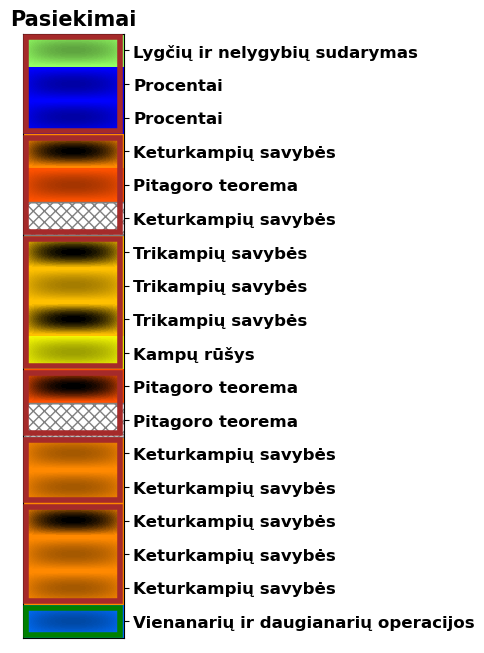

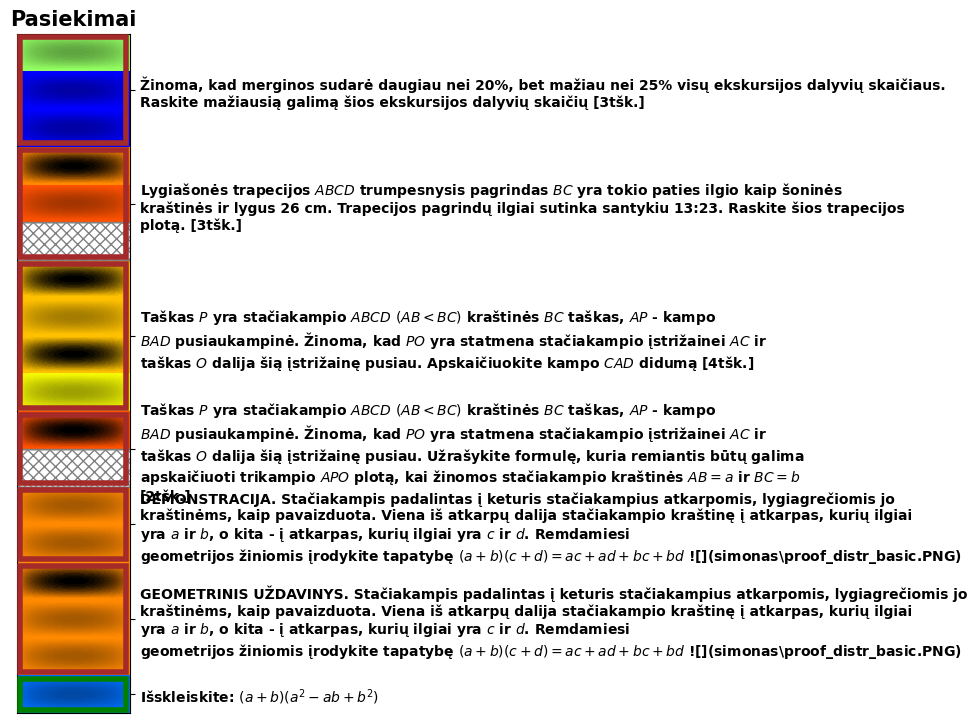

ValueError: 
\triangle APO = \triangle POC
^
Unknown symbol: \triangle, found '\'  (at char 0), (line:1, col:1)

<Figure size 300x900 with 1 Axes>

In [51]:
summary = Summary(lesson_df)
colors = summary.get_colors('licejus/clusters.txt')
summary.add_summary(colors, mode = 'abstract', figsize=(1.3,9))
summary.add_summary(colors, mode = 'real', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(3,9), wrapping=100)
summary.add_summary(colors, mode = 'full', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(3,9), wrapping=100)

### Kaip vertinamos moksleivio žinios kiekvienoje srityje?
Moksleiviui dažniausiai nesiseka iki galo išspręsti daugelio uždavinių, todėl pamokos metu jis yra klausinėjamas ir tokiu būdu paaiškėja, kiek jis turi gebėjimų atlikti atskiras dalis.

**Rezultatai atskirose disciplinose**:

* Skaičiai ir skaičiavimai: (4, 8),
* Reiškiniai, lygtys, nelygybės: (3, 6),
* Geometrija: (1, 2),
* Kombinatorika: (1, 1)

### Rezultatai
Vizualiai pavaizdavus gautus rezultatus matome tokį vaizdą:

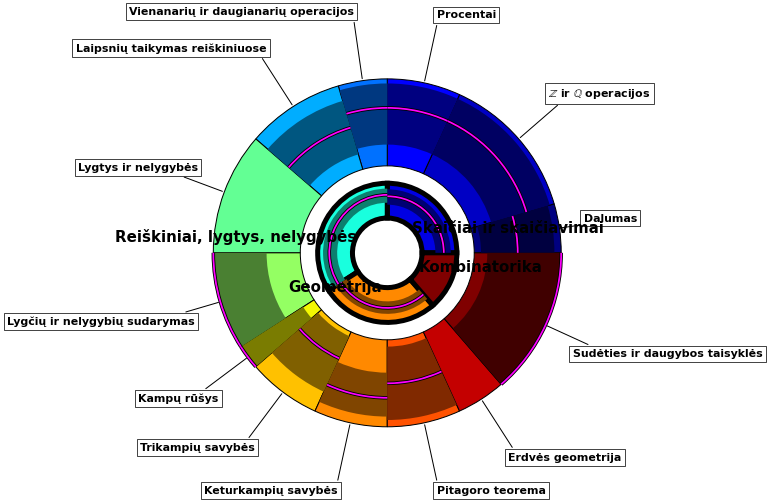

In [62]:
lesson_df = lesson_df_overall
intervals = np.sort(np.random.random((12, 2)), axis=1)
mids = np.random.random(12)

#vaizduojama karkasas: pasiskirstymas, bet be papildomos informacijos
skills = Skills('licejus/clusters.txt', 'licejus/2017', 'licejus/2018')
skills.plot()

df1 = lesson_df[['skill', 'solved_partially']].groupby('skill').sum().astype(int)
correct = df1.to_dict()['solved_partially']
df2 = lesson_df[['skill', 'solved_partially']].groupby('skill').count().astype(int)
total = df2.to_dict()['solved_partially']

index = dict(zip(skills.distribution.keys(), [[m for m in list(n) if m in correct] for n in skills.distribution.values()]))

for subject in index:
    for i in range(len(index[subject])):
        topic = index[subject][i]
        if topic in correct:
            index[subject][i] = (correct[topic], total[topic])
            
for n in index:
    if index[n]:
        index[n] = tuple(np.sum(index[n], axis=0))
    else:
        index[n] = tuple(np.array([0, 0]))

outer_rates = dict(zip(correct.keys(), zip(correct.values(), total.values())))
distribution = dict(zip(skills.outer_names, [(0,0)]*len(skills.outer_names)))
for n in outer_rates:
    distribution[n] = outer_rates[n]
skills.draw_outer_rates(distribution, Q=0.7, lower_bound=1)
skills.draw_inner_rates(index, Q=0.7, lower_bound=4)
plt.show()

#index - disciplinų duomenys
#distribution - gebėjimų duomenys

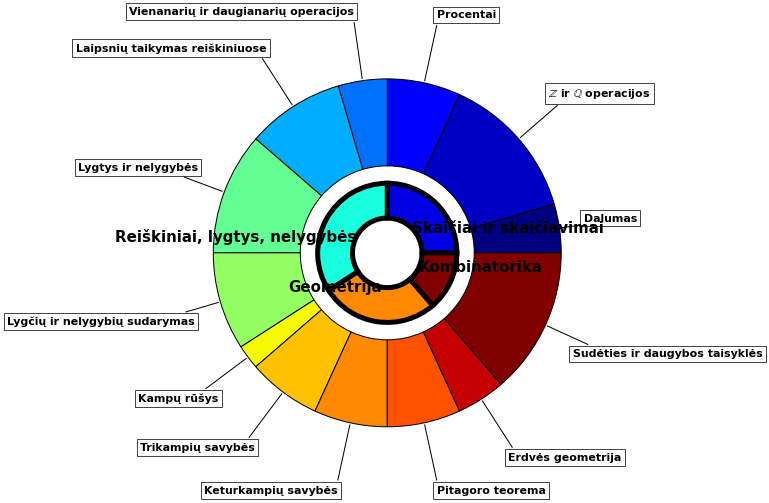

In [63]:
skills = Skills('licejus/clusters.txt', 'licejus/2017', 'licejus/2018')
skills.plot()

### Diagramos paaiškinimai
![](instructions.PNG)

In [61]:
import json
from IPython.display import display, Markdown
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mlc
import numpy as np
from itertools import chain, compress
from io import StringIO
import pandas as pd
import scipy.stats
import math
import matplotlib.patches as patches 
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm 
import textwrap


def read_json(file):
    with open(file, encoding='utf-8') as fh:
        data = json.loads(fh.read())
    return data

def document_it(clusters, branches):
    clusters = read_json(clusters)
    branches = read_json(branches)
    headings = dict(zip([clusters[n][0] for n in clusters], clusters))
    docstring = ''
    for branch in branches:
        if branch in headings:
            docstring += f'\n### {headings[branch]}\n\n'
        docstring += f'* **{branch}.** {branches[branch]}\n'
    return docstring

def make_some_bank(*files, extention='.txt', show_solution=False):
    docstring = ''
    for file in files:
        heading = os.path.splitext(file)[0]
        docstring += f'\n### {heading}\n'
        bank = read_json(file + extention)
        for užduotis in bank:
            docstring += f"{užduotis}\\. {bank[užduotis]['Sąlyga']}"+'\n\n'
            if show_solution:
                docstring+=('\n\n**Sprendimas.**\n' + '\n'.join([f'* {n}' for n in bank[užduotis]["Sprendimas"]])+'\n\n')
    return docstring

def show_problem(complect, id, show_solution=True):
    problem = read_json(f'{complect}.txt')[id]
    step = '**Užduotis.**\n\n' + problem["Sąlyga"]
    if show_solution: step += ('\n\n**Sprendimas.**\n' + '\n'.join([f'* {n}' for n in problem["Sprendimas"]]))
    return step

def show_case(complect, id, which=1, show_solution=True):
    skills = read_json(f'{complect}.txt')[id]["Gebėjimai"][which-1]
    step = '**Uždavinio dalis ' + f"{which}, kurioje yra {skills['Gebėjimas']}" + '.**\n\n' + skills['Atitikmuo']
    if show_solution: step += ('\n\n**Sprendimas.**\n\n' + skills['Sprendimas'])
    return step
    
def show_skill(skill, *files, extention='.txt'):
    counter = 0
    docstring = f'### Uždaviniai[@], kuriuose yra {skill}: \n\n'
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extention)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if gebėjimas['Gebėjimas'] == skill:
                    counter +=1 
                    if len(bank[užduotis]['Gebėjimai'])!=1:
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {gebėjimas['Atitikmuo']}\n\n"
                    else: 
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {bank[užduotis]['Sąlyga']}\n\n"
                else: #expects to have just a list of skills without dict of descriptions - OUTDATED
                    if gebėjimas == skill:
                        counter +=1
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {bank[užduotis]['Sąlyga']}\n\n"
    return docstring.replace('@', str(counter))

def get_analysis(*files, extension='.txt'):
    skills = defaultdict(list)
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extension)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if type(gebėjimas) is dict:
                    skills[gebėjimas['Gebėjimas']].append(f"{heading}.{užduotis}->{idx+1}")
                else:
                    skills[gebėjimas].append(f"{heading}.{užduotis}->{idx+1}")
    return skills

def check(name, problem_id, extension='.txt'):
    display(Markdown(show_problem(name, problem_id, show_solution=True)))
    problem = read_json(name + extension)
    for i in range(len(problem[problem_id]['Gebėjimai'])): 
        display(Markdown('-'*100))
        display(Markdown(show_case(name, problem_id, which=i+1, show_solution=True)))

def check_skills(name, problem_id, extension='.txt'):
    problem = read_json(name + extension)
    return [n['Gebėjimas'] for n in problem[problem_id]['Gebėjimai']]

def get_distribution(cluster_file, *files):
    analysis = get_analysis(*files)
    branch_counts = defaultdict(int)
    for branch in analysis:
        branch_counts[branch] += len(analysis[branch])
    clusters = read_json(cluster_file)
    d = dict()
    for cluster in clusters:
        bc = dict()
        for branch in clusters[cluster]:
            bc[branch] = branch_counts[branch]
            branch_counts.pop(branch)
        d[cluster] = bc
    if len(branch_counts):
        print('WARNING! Some problems contain skills that are not in clusters:\n', branch_counts)
    return d

class Skills:
    kw = dict(bbox=dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.72),
          arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    cmap = plt.get_cmap("jet")
    
    def __init__(self, clusters_file, *files):
        self.distribution = get_distribution(clusters_file, *files)
        
    def set_diagram(self):
        self.inner_names = list(self.distribution.keys()) #clusters
        self.outer_names = list(chain(*[list(n.keys()) for n in self.distribution.values()])) #branches of clusters
        
        self.outer_values = np.array(list(chain(*[list(n.values()) for n in self.distribution.values()]))) #sizes of branches in each cluster
        self.inner_values = np.array([sum(n.values()) for n in self.distribution.values()]) #sizes of clusters
        
        self.inner_idx = np.flatnonzero(self.inner_values) #idx of nonzero inner values
        self.outer_idx = np.flatnonzero(self.outer_values) #idx of nonzero outer values

    def set_colors(self):
        self.set_diagram()
        marker_idx = np.cumsum([len(n) for n in self.distribution.values()])[:-1] #idx where to split flat data
        outer_spectrum = np.linspace(0, 1, len(self.outer_values))
        inner_spectrum = np.array([np.mean(n) for n in np.split(outer_spectrum, marker_idx)])        
        self.inner_colors = self.cmap(inner_spectrum)
        self.outer_colors = self.cmap(outer_spectrum)

    def flatnonzero(self):
        #remove zero pieces which is illegal
        self.inner_names = np.array(self.inner_names)[self.inner_idx]
        self.outer_names = np.array(self.outer_names)[self.outer_idx]
        self.inner_values = self.inner_values[self.inner_idx]
        self.outer_values = self.outer_values[self.outer_idx]
        self.inner_colors = self.inner_colors[self.inner_idx]
        self.outer_colors = self.outer_colors[self.outer_idx]
                                  
    def get_inner_pie(self):
        wedges, text = plt.gca().pie(self.inner_values, labels = self.inner_names, labeldistance=0.5, 
                                     radius=0.4, colors=self.inner_colors, wedgeprops=dict(width=0.2, edgecolor='k', linewidth=5), 
                                     textprops=dict(fontsize=15, fontweight='bold'))
        return wedges
    f
    def add_outer_ranges(self, intervals):
        #add mid coloring that marks knoledge
        for i in range(len(self.outer_values)):
            if not (math.isnan(intervals[i][0]) and math.isnan(intervals[i][1])):
                none = np.empty_like(self.outer_colors)
                none[:] = np.nan
                none[:,3] = np.nan
                none[i] = self.outer_colors[i]/2
                none[i,3] = 1
                plt.gca().pie(self.outer_values, radius=0.5+0.5*intervals[i][1], colors=none, 
                                    wedgeprops=dict(width=0.5*(intervals[i][1] - intervals[i][0]), edgecolor='none'))
        
        
    def add_outer_mids(self, midvalues, width=0.01):
        #add mid coloring that marks knoledge
        for i in range(len(self.outer_values)):
            if not math.isnan(midvalues[i]):
                #double line
                none = np.empty_like(self.outer_colors)
                none[:] = np.nan
                none[:,3] = np.nan
                none[i] = [0,0,0,1]
                plt.gca().pie(self.outer_values, radius=0.5+0.5*midvalues[i]+2*width/2, colors=none, 
                                    wedgeprops=dict(width=2*width, edgecolor='none'))
                #mid line
                none = np.empty_like(self.outer_colors)
                none[:] = np.nan
                none[:,3] = np.nan
                none[i] = [1,0,1,1]
                plt.gca().pie(self.outer_values, radius=0.5+0.5*midvalues[i]+width/2, colors=none, 
                                    wedgeprops=dict(width=width, edgecolor='none'))
                
    def add_inner_ranges(self, intervals):
        #add mid coloring that marks knoledge
        for i in range(len(self.inner_values)):
            if not (math.isnan(intervals[i][0]) and math.isnan(intervals[i][1])):
                none = np.empty_like(self.inner_colors)
                none[:] = np.nan
                none[i] = self.inner_colors[i]/2
                none[i,3] = 1
                plt.gca().pie(self.inner_values, radius=0.2+0.2*intervals[i][1], colors=none, 
                                    wedgeprops=dict(width=0.2*(intervals[i][1] - intervals[i][0]), edgecolor='none'))
        
        
    def add_inner_mids(self, midvalues, width=0.01):
        #add mid coloring that marks knoledge
        for i in range(len(self.inner_values)):
            if not math.isnan(midvalues[i]):
                #double line
                none = np.empty_like(self.inner_colors)
                none[:] = np.nan
                none[:,3] = np.nan
                none[i] = [0,0,0,1]
                plt.gca().pie(self.inner_values, radius=0.2+0.2*midvalues[i]+2*width/2, colors=none, 
                                    wedgeprops=dict(width=2*width, edgecolor='none'))
                #mid line
                none = np.empty_like(self.inner_colors)
                none[:] = np.nan
                none[i] = [1,0,1,1]
                plt.gca().pie(self.inner_values, radius=0.2+0.2*midvalues[i]+width/2, colors=none, 
                                    wedgeprops=dict(width=width, edgecolor='none'))
            
    def draw_outer_rates(self, distribution=None, Q=0.7, lower_bound=5):
        #take dict like self.distribution with values (a, t) where a=answered, t=total. PLEASE PRESERVE ORDER
        #draw rates with 70% confidence
        ranges, mids = [], []
        for a, t in distribution.values():
            if t>=lower_bound:
                p = a/t
                q = 1-p
                n = t
                v1=2*(n*q+1)
                v2=2*n*p
                v3=2*(n*p+1)
                v4=2*n*q
                CL = 1/(1 + (scipy.stats.f.ppf((1+Q)/2, v1, v2)*(q + 1/n)/p)) # CL
                CU = 1/(1+(q/(1/n+p)/scipy.stats.f.ppf((1+Q)/2, v3, v4))) # CU
                if a==0: CL=0
                if a==t: CU=1
                ranges.append((CL, CU))
                mids.append(p)
            else:
                ranges.append((np.nan, np.nan))
                mids.append(np.nan)
                
        self.add_outer_ranges(ranges)
        self.add_outer_mids(mids)
        
    def draw_inner_rates(self, distribution=None, Q=0.7, lower_bound=5):
        #take dict like self.distribution with values (a, t) where a=answered, t=total. PLEASE PRESERVE ORDER
        #draw rates with 70% confidence
        ranges, mids = [], []
        for a, t in distribution.values():
            if t>=lower_bound:
                p = a/t
                q = 1-p
                n = t
                v1=2*(n*q+1)
                v2=2*n*p
                v3=2*(n*p+1)
                v4=2*n*q
                CL = 1/(1 + (scipy.stats.f.ppf((1+Q)/2, v1, v2)*(q + 1/n)/p)) # CL
                CU = 1/(1+(q/(1/n+p)/scipy.stats.f.ppf((1+Q)/2, v3, v4))) # CU
                if a==0: CL=0
                if a==1: CU=1
                ranges.append((CL, CU))
                mids.append(p)
            else:
                ranges.append((np.nan, np.nan))
                mids.append(np.nan)
                
        self.add_inner_ranges(ranges)
        self.add_inner_mids(mids)
        
    def get_outer_pie(self):
        wedges, text = plt.gca().pie(self.outer_values, radius=1, colors=self.outer_colors, 
                                wedgeprops=dict(width=0.5, edgecolor='k'))
        return wedges
                     
    def add_labels(self, wedges):
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle, angleA=0, angleB={ang}"
            self.kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.gca().annotate(self.outer_names[i], xy=(x, y), xytext=(1.35*np.sin(x), 1.4*y),
                        horizontalalignment=horizontalalignment, fontsize=11, fontweight='bold', **self.kw)
                                  
    def plot(self, intervals=None):
        #additional data adds a piece of knowledge
        fig = plt.figure(figsize=(8, 8))
        plt.gca().set(aspect="equal")
        self.set_diagram()
        self.set_colors()
        self.flatnonzero()
        self.get_inner_pie()
        wedges = self.get_outer_pie()
        self.add_labels(wedges)
        
    
def get_data(text):
    df = pd.read_csv(StringIO(text), sep=" ")
    df.set_index(['author', 'topic','problem_id'], inplace=True)
    df1 = df[df['part']==0]
    df2 = df[df['part']!=0]
    df3 = pd.concat([df1, df2]).sort_values(by=['part'])
    df3 = df3[~df3.index.duplicated(keep='first')]
    df3['solved'][df3['part']!=0] = None
    df3 = df3.drop('part', 1)
    df3['skills'] = [tuple([n['Gebėjimas'] for n in read_json(f'{x}/{y}.txt')[str(z)]['Gebėjimai']]) for x,y,z in df3.index]
    df3['pts'] = [len(n) for n in df3['skills']]
    df4 = df3.copy()
    part = df3.loc[df3.index.repeat(df3['pts'])].groupby(['author', 'topic', 'problem_id']).cumcount() + 1
    df4 = pd.DataFrame(part, columns=['part'])
    df4['skill'] = list(chain(*df3['skills']))
    df5 = df4.merge(df2, on=['author', 'topic', 'problem_id', 'part'], how='outer')
    for n in df3[df3['solved']==True].index: 
        df5.loc[n, 'solved'] = True
    return df3, df5

def achievements(df5, df3, colors):
    vals_big = np.array([n if n == n else -1 for n in df5['solved'].values.tolist()]).astype(int)
    vals_small = np.array([n if n == n else -1 for n in df3['solved'].values.tolist()]).astype(int)
    img = vals_big[:, None]
    completed = df3['pts'].values
    shape = img.shape

    figure, ax = plt.subplots(figsize=(6,8))

    #x.set_xlabel('Activity', fontsize=13)
    #ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold', minor=False)
    ax.set_yticks(np.arange(-0.5+0.5, img.shape[0]+0.5, 1)) #borders between edges
    ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold')
    ax.set_ylim(-0.5, img.shape[0]-0.5)
    #ax.set_xticklabels(np.arange(1, img.shape[1] + 1, 1))

    #ax.set_ylabel('States', fontsize=13)
    ax.set_xticks(np.arange(0, 1, 1))
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    #ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    #ax.set_yticklabels(states)

    a=0.05
    pal = {1: 'none', 0: 'red', -1: 'grey'}
    for idx, clr in enumerate(colors):
        if vals_big[idx]!=-1:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor=clr, edgecolor = pal[vals_big[idx]], hatch=r'xxx', zorder=0))
        else:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor='none', edgecolor = pal[vals_big[idx]], hatch=r'xxx'))
        
    pallete = {1: 'limegreen', 0: 'crimson', -1: 'none'}
    starts, sizes = np.cumsum(np.r_[0, df3['pts'].values[:-1]]), np.r_[df3['pts'].values]
    for start, size, solved in zip(starts, sizes, vals_small):
        ax.add_patch(plt.Rectangle((-0.5+a, start-0.5+a), 1-2*a, size-2*a, 
                                   facecolor='none', edgecolor = pallete[solved], zorder=1, lw=4, linestyle='--'))
    
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()

    
    ax.grid(which='minor', color='k')
    ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
    plt.gca().invert_yaxis()
    #plt.gca().majorticks_off()
    plt.show()


class Summary:
    def __init__(self, lesson_df):
        self.lesson_df = lesson_df
        
    def get_colors(self, clusters):
        skills = []
        for n in read_json(clusters).values():
            skills.extend(n)

        idx = [skills.index(n) for n in self.lesson_df['skill']]
        palette = plt.get_cmap('jet')(np.linspace(0, 1, len(skills)))
        colors = palette[idx]
        return colors
        
    def add_summary(self, colors, mode = 'abstract', height=10, width=30, 
                    fixes={'\\boxed': '', '\\sin': '\\cos'}, figsize=(6,8), wrapping=50):
        groupby = self.lesson_df.groupby(['author', 'topic', 'problem_id'], sort=False)
        chunk_sizes = groupby.size().values
        chunk_values = groupby.nth(0)['solved_fully'].values
        figure, ax = plt.subplots(figsize = figsize, dpi=100)


        ax.set_xticks(np.arange(0, width, width))
        ax.get_xaxis().set_visible(False)
        ax.set_xlim(0, width)

        a=0.05
        
        # Full rectangles
        pallete = {1: 'green', 0: 'brown'}
        yticks = []
        for start, size, solved in zip(np.cumsum(np.r_[0, chunk_sizes[:-1]]), chunk_sizes, chunk_values):
            box_position = height * (start+size/2)
            yticks.append(box_position)
            if not math.isnan(solved):
                rect = patches.Rectangle((-0.5*width, start*height+ height/2), width, size*height, facecolor='none')
                offsetbox = AuxTransformBox(ax.transData)
                offsetbox.add_artist(rect)
                ab = AnnotationBbox(offsetbox, (width/2, box_position),
                                    boxcoords="data", pad=-0.62,fontsize=4,
                                    bboxprops=dict(facecolor = "none", edgecolor=pallete[solved], 
                                              lw = 4))
                ax.add_artist(ab)
                
                
            else:
                ax.add_patch(plt.Rectangle((0, (start-0.5)*height), width, size*height, 
                                           facecolor='none', edgecolor = 'none', zorder=1, lw=4, linestyle='--'))
        
        # Partial rectangles
        for idx, clr in enumerate(colors):
            point = self.lesson_df['solved_partially'][idx]
            if math.isnan(point):
                ax.add_patch(plt.Rectangle((0, idx*height), width, height, facecolor='none', edgecolor = 'grey', hatch=r'xxx'))
            else:
                s = {True: 0.65, False: 0}[point]
                rectangle = patches.Rectangle((0, idx*height), width, height, facecolor=clr, 
                                           edgecolor = 'k', hatch=r'xxx', zorder=0)
                ax.add_patch(rectangle)
                
                #clip your colors here
                cell = (np.sin(np.linspace(0, np.pi, height)[:, np.newaxis]) * np.cos(np.linspace(-np.pi/2, np.pi/2, width))**0.5)
                col = np.c_[np.linspace(clr[0], clr[0]*s, 20),
                          np.linspace(clr[1], clr[1]*s, 20), 
                          np.linspace(clr[2], clr[2]*s, 20),
                          np.ones(20)]
                im = ax.imshow(cell, interpolation ='bicubic', cmap = ListedColormap(col), extent = (0, width, idx*height, (idx+1)*height))
                im.set_clip_path(rectangle)
              
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        
        if mode == 'abstract':
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(self.lesson_df['skill'].values, rotation='horizontal', fontsize=12, fontweight='bold')

        elif mode == 'real':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]['Sąlyga']
                problems.append(self.entering(self.parse_exception(u, fixes), wrapping=wrapping))

            ax.set_yticks(yticks)
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')
        
        elif mode == 'full':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]
                point_names = [self.entering(self.parse_exception(p['Atitikmuo'], fixes), wrapping=wrapping) for p in u['Gebėjimai']]
                if len(point_names) == 1:
                    problems.append(self.entering(self.parse_exception(u['Sąlyga'], fixes), wrapping=wrapping))
                else:
                    problems.extend(point_names)
                    
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')

        ax.set_ylim(0, len(self.lesson_df) * height)
        
        ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
        #ax.tick_params(axis='y', which='major', right=False) #might this help to extend plot
        plt.gca().invert_yaxis()
        plt.show()
    
    @staticmethod
    def parse_exception(text, fixes={}):
        for n in fixes:
            text = text.replace(n, fixes[n])
        return text
    
    @staticmethod
    def entering(text, wrapping=100):
        se = np.array([m.start() for m in re.finditer(r"(?=\$)", text)])
        if len(se):
            se = se.reshape(-1, 2) + (0, 1)
            forward = dict((text[s[0]:s[1]], str(np.random.randint(1000000000))) for s in se)
            backward = dict((forward[n], n) for n in forward)

            for n in forward:
                text = text.replace(n, forward[n])
            out_text = '\n'.join(textwrap.wrap(text, width=wrapping))
            
            for n in backward:
                out_text = out_text.replace(n, backward[n])
            return out_text
        else:
            return '\n'.join(textwrap.wrap(text, width=wrapping))
    
    
        
#Jei prireiks - uždavinių rūšiavimas pagal numerius
import re
def argsort_problems(problem_ids):
    keys = [re.match(r'(\d*)(.*)', s).groups() for s in problem_ids]
    keys = [(int(num), ord(letters)) if letters else (int(num), 0) for num, letters in keys]
    sorter = np.ravel_multi_index(np.array(keys).T, (256, 256))
    return np.argsort(sorter)

class Lesson:
    def __init__(self, text):
        self.df = pd.read_csv(StringIO(text), sep=" ")
        self.df.set_index(['author', 'topic','problem_id'], inplace=True)

    def analyse_problems(self):
        # analysis on every problem_id or its part attempted based on metadata; no scoring
        skills, pts = [], []
        for problem in self.df.index.unique():
            author, topic, problem_id = problem
            metadata = read_json(f'{author}/{topic}.txt')
            problem_data = metadata[str(problem_id)]['Gebėjimai']
            problem_skills = [n['Gebėjimas'] for n in problem_data]
            skills.append(problem_skills)
            pts.append(len(problem_skills))
        self.problems_df = pd.DataFrame({'skills': skills, 'pts': pts}, index = self.df.index.unique())

    def analyse_points(self):
        # creates a span of point_ids for every problem_id and extracts skills from self.problems_df; no scoring
        self.analyse_problems()
        multi_idx = self.problems_df.index
        point_series = self.problems_df.loc[multi_idx.repeat(self.problems_df['pts'])].groupby(multi_idx.names).cumcount() + 1
        skill = list(chain(*self.problems_df['skills']))
        self.points_df = pd.DataFrame({'point_id': point_series.values, 'skill': skill}, index = point_series.index)

    def check_solutions(self):
        # scoring of full solutions + partial solutions; combines solution with metadata of problems & points
        self.analyse_points()
        df1 = self.df[self.df['point_id']==0]
        df2 = self.df[self.df['point_id']!=0]
        df2 = df2.reset_index().set_index(['author', 'topic', 'problem_id', 'point_id'])
        self.points_df.loc[df1.index, 'solved_fully'] = df1['solved']
        self.points_df = self.points_df.reset_index().set_index(['author', 'topic', 'problem_id','point_id'])
        self.points_df.loc[df2.index, 'solved_partially'] = df2['solved']

    def fix_typos(self):
        # typos of any of these kinds:
        # * if solved fully, all the partial solutions becomes right
        # * if any partial solution not right, it's not solved fully
        # * except the case there are not attempted partial solutions; it makes a full solution not attempted as well
        self.check_solutions()
        df = self.points_df
        df.loc[df['solved_fully'] == True, 'solved_partially'] = True
        df = df.reset_index().set_index(['author', 'topic', 'problem_id'])
        df.loc[(df['solved_partially'] == False).index, 'solved_fully'] = False
        df.loc[df['solved_partially'].isnull().index, 'solved_fully'] = np.nan
    
    def get_lesson(self):
        self.fix_typos()
        return self.points_df